In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models,regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import cv2

In [ ]:
folder_path='/content/drive/MyDrive/archive (50)/data'
train_path='/content/drive/MyDrive/archive (50)/data/train'
test_path='/content/drive/MyDrive/archive (50)/data/test'

**Loading Data**

In [ ]:
def load_img(folder_path,limit,size=(128,128)):
  images=[]
  labels=[]
  categories=['benign','malignant']

  for label,category in enumerate(categories):
    category_path=os.path.join(folder_path,category)
    count=0
    for file in os.listdir(category_path):
      img_path=os.path.join(category_path,file)
      img=cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      if img is None:
        print(f" Unable to read file {img_path}.")
        continue
      img=cv2.resize(img,size)
      images.append(img)
      labels.append(label)
      count+=1
      if count==limit:
        break
  return images,labels


In [ ]:
train_i,train_l=load_img(train_path,5000)
test_i,test_l=load_img(test_path,2000)

**Converting Images into Array**

In [ ]:
train_images=np.array(train_i)
train_labels=np.array(train_l)
test_images=np.array(test_i)
test_labels=np.array(test_l)

In [ ]:
print(train_images.shape)
print(test_images.shape)

(2647, 128, 128, 3)
(670, 128, 128, 3)


**Plotting** **Images** **Sample**

(-0.5, 127.5, 127.5, -0.5)

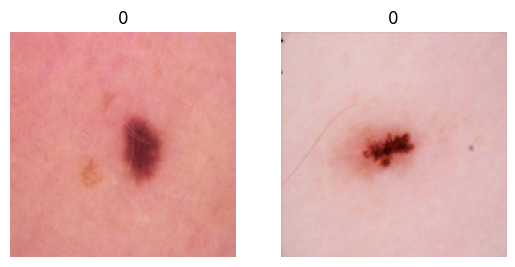

In [ ]:
plt.subplot(1,2,1)
plt.imshow(train_images[0])
plt.title(train_labels[0])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(test_images[1])
plt.title(test_labels[1])
plt.axis('off')

**Data Augmentation**

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)
aug_iterator=datagen.flow(train_images,train_labels,batch_size=128)
augmented_images=[]
augmented_labels=[]
for i in range(10):
  augmented_image_b,augmented_label_b=next(aug_iterator)
  augmented_images.extend(augmented_image_b)
  augmented_labels.extend(augmented_label_b)
augmented_images=np.array(augmented_images)
augmented_labels=np.array(augmented_labels)

In [ ]:
print(augmented_images.shape)
print(augmented_labels.shape)

(1280, 128, 128, 3)
(1280,)


In [ ]:
augmented_train_images_resized = tf.image.resize(augmented_images, (224, 224))
train_images = np.concatenate((train_images, augmented_images), axis=0)
train_images.shape

(3927, 128, 128, 3)

In [ ]:
train_labels=np.concatenate((train_labels,augmented_labels),axis=0)
train_labels.shape

(3927,)

**Label Categorization**

In [ ]:
from keras.utils import to_categorical
train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)
train_labels.shape

(3927, 2)

**Normalization**

In [ ]:
train_images=train_images/255
test_images=test_images/255

**CNN Training**

In [ ]:
model=models.Sequential([
    #cnn
    layers.Conv2D(filters=16,kernel_size=(3,3),input_shape=(128,128,3),padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),
    #dense
    layers.Flatten(),
    layers.Dense(500,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64,activation='relu'),
    layers.Dense(2,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 500)                 │       4,096,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,266,454 (16.28 MB)

 Trainable params: 4,266,454 (16.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_images,train_labels,epochs=10)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.6429 - loss: 0.6000
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7734 - loss: 0.4564
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7992 - loss: 0.4190
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8065 - loss: 0.3972
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8205 - loss: 0.3845
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8253 - loss: 0.3620
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8326 - loss: 0.3343
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8246 - loss: 0.3542
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8571 - loss: 0.3143
Epoch 10/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8739 - loss: 0.2829


**Evaluating The Model**

In [ ]:
test_result=model.evaluate(test_images,test_labels)
print(f"Accuracy on Testing: {test_result[1]*100}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8695 - loss: 0.2819
Accuracy on Testing: 85.8208954334259


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
y_pred=model.predict(test_images)
test_labels = np.argmax(test_labels, axis=1)
y_pred = np.argmax(y_pred, axis=1)
report=classification_report(test_labels,y_pred)
print(report)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       370
           1       0.85      0.84      0.84       300

    accuracy                           0.86       670
   macro avg       0.86      0.86      0.86       670
weighted avg       0.86      0.86      0.86       670



**Saving the Model**

In [ ]:
from tensorflow.keras.models import load_model
model.save(r'skincancer.h5')